In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base  import ForecastingHorizon
from sktime.forecasting.trend import PolynomialTrendForecaster

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer,Detrender

from sklearn.neighbors import KNeighborsRegressor

In [136]:
def resample_fix_ends(pdf,frequency):
  """
  The function resamples the data according to the sampling frequency. 
  Often the first and the last data-point are deviating a lot from the rest of the series.
  
  As a simple fix i will just delete the first and the last value if they deviate more than 20% to their neighbour. 
  """

  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"

  for column in pdf.columns:
    if pdf[column].iloc[0] < 0.8*pdf[column].iloc[1]:
      pdf = pdf.drop(pdf.index[0]) 
      #pdf.at[pdf.index[0],column]   = pdf[column].iloc[1] #this would assigne the value of the next day to the first day.

    if pdf[column].iloc[-1] < 0.8*pdf[column].iloc[-2]:
      pdf = pdf.drop(pdf.index[-1]) 
      #pdf.at[pdf.index[-1],column]  = pdf[column].iloc[-2] #this would assigne the value of the second last day to the last day.

  return pdf

def reassign_outliers(pdf):
  """There is an extrem outlier in the data which is probably a mistake. I will reassign the value to it's neighbour."""

  for column in pdf.columns:
    
    outlier_loc = np.where(pdf[column] < np.mean(pdf[column])-3*np.std(pdf[column]))
    (pdf[column].values)[outlier_loc] = np.mean(pdf[column]) 

    print(f"Reassigned {len(outlier_loc)} values in the column {column}. These values where more than 3 sigma away from the mean.")

  return pdf


In [137]:
# url = "https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich/download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv"
# pdf = pd.read_csv(url,index_col=None)


pdf = pd.read_csv("../data/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)
pdf["Timestamp"] =  pd.to_datetime(pdf['Timestamp'],utc=True)
pdf = pdf.set_index(pdf["Timestamp"])

pdf = resample_fix_ends(pdf,"D")
pdf = reassign_outliers(pdf)

pdf.index = pdf.index.tz_localize(None)  #Let's drop the timezone info to avoid warnings


# let's rescale the data with a min-max scaler --> scale to [0,1]
scaler = preprocessing.MinMaxScaler()
#pdf["y"] = scaler.fit_transform((pdf["Value_NE5"].values + pdf["Value_NE7"].values).reshape(-1, 1))
#pdf = pdf.drop(columns=["Value_NE5","Value_NE7"])

pdf["y"] = scaler.fit_transform((pdf["Value_NE7"].values).reshape(-1, 1))
pdf = pdf.drop(columns=["Value_NE5","Value_NE7"])

#split data in train val and test
#2657/365/(days since first december last year) 
# calculate the number of days from the last datapoint to the 1st of December 2022
n_test = (pdf.index[-1] -pd.to_datetime("2022-11-30")).days

split = len(pdf)-365-n_test
pdf_train, pdf_val, pdf_test = pdf.iloc[:split], pdf.iloc[split:split+365], pdf.iloc[split+365:]

Reassigned 1 values in the column Value_NE5. These values where more than 3 sigma away from the mean.
Reassigned 1 values in the column Value_NE7. These values where more than 3 sigma away from the mean.


C:\Users\ewzbusi\AppData\Local\Temp\ipykernel_3252\3593820342.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"


In [138]:

#regressor = KNeighborsRegressor(n_neighbors=1)

forecaster = TransformedTargetForecaster(
    [
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("deseasonalize", Deseasonalizer(model="additive", sp=7)),
        ("deseasonalize", Deseasonalizer(model="additive", sp=365)),
        ("forecast", ARIMA() )  
        #("forecast", regressor )
    ]
)

# forecaster = make_reduction(regressor, window_length=15, strategy="recursive")

y_train = pdf_train['y'].squeeze().asfreq(freq='D')
forecaster.fit(y_train)
horizon = ForecastingHorizon(pdf_test.index, is_relative=False)
y_pred  = forecaster.predict(fh=horizon)


In [139]:
#use validation set to improve model. 

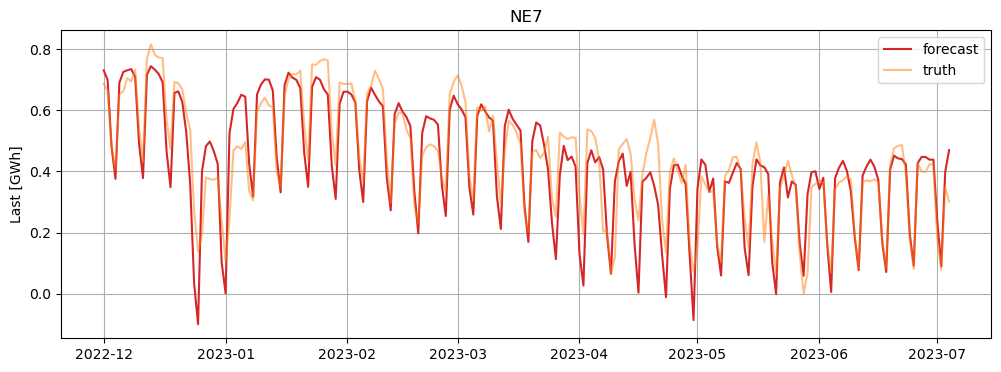

In [140]:
f, axes = plt.subplots(1, 1, figsize=(12, 4))


axes.plot(y_pred, color="tab:red", label="forecast")
# axes.plot(pdfTrain.ds.values, pdfTrain.y.values, color="tab:blue", label="train")
axes.plot(pdf_test, color="tab:orange", label="truth", alpha=0.5)
axes.legend()
axes.set_title("NE7")
axes.set_ylabel("Last [GWh]")
axes.grid()

# xmin, xmax = axes[0].get_xlim()
# axes[1].plot(pdf_test.index, (y_pred.values - pdf_test.y.values)*100) # / (pdf_test.y.values+y_pred.values)*100)
# axes[1].set_xlim(xmin, xmax)
# axes[1].set_ylabel("residual: (Pred-True)/True [%]")

plt.show()

In [141]:
print(f"RMSE: {mean_squared_error(y_pred, pdf_test.y.values, squared=False)}")


RMSE: 0.0869568378119767


### Better apply monthly Aggregation or directly train on Monthly? 

In [142]:
prediction = pd.DataFrame(scaler.inverse_transform((y_pred.values).reshape(-1, 1)).flatten(), columns=['y'])
prediction.index = y_pred.index

test = pd.DataFrame(scaler.inverse_transform((pdf_test.values).reshape(-1, 1)).flatten(), columns=['y'])
test.index = y_pred.index

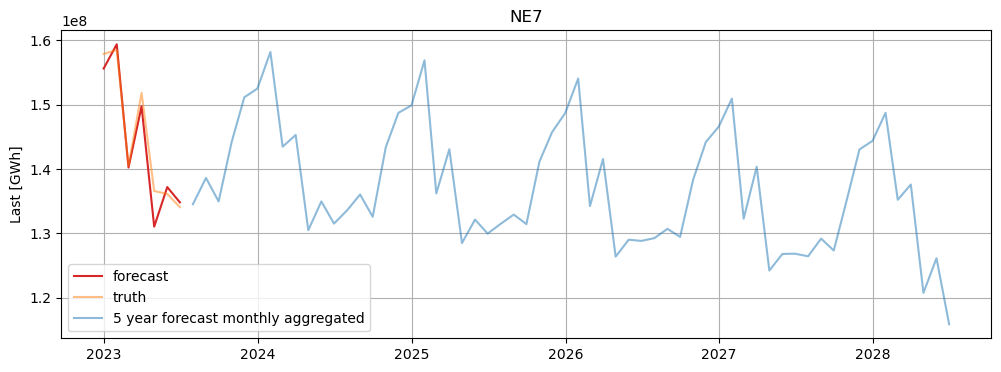

In [143]:
f, axes = plt.subplots(1, 1, figsize=(12, 4))

prediction = resample_fix_ends(prediction, "M")
test = resample_fix_ends(test, "M")
axes.plot(prediction, color="tab:red", label="forecast")
axes.plot(test, color="tab:orange", label="truth", alpha=0.5)

#create datetimerange from first of july 2023 to + 5 years
fiveyears = pd.date_range("2023-07-01", periods=365*5, freq="D")
horizon = ForecastingHorizon(fiveyears, is_relative=False)
fiveYearPrediction  = forecaster.predict(fh=horizon)

fiveYearPrediction = pd.DataFrame(scaler.inverse_transform(fiveYearPrediction.values.reshape(-1,1)).flatten(), index=fiveYearPrediction.index, columns=["y"])
axes.plot(resample_fix_ends(fiveYearPrediction, "M"), color="tab:blue", label="5 year forecast monthly aggregated", alpha=0.5)
# axes.plot(fiveYearPrediction/4e6, color="tab:green", label="5 year forecast daily", alpha=0.5)
# axes.plot(prediction.resample("M").sum(min_count=1), color="tab:blue", label="forecast",alpha=0.5)
# axes.plot(test.resample("M").sum(min_count=1), color="tab:green", label="truth", alpha=0.5)
axes.legend()
axes.set_title("NE7")
axes.set_ylabel("Last [GWh]")
axes.grid()

plt.show()

In [144]:
print(f"RMSE: {mean_squared_error(prediction.y.values, test.y.values, squared=False)}")

RMSE: 2466512.162853918


In [208]:
# Train on montly
pdf_train = resample_fix_ends(pdf_train, "M")
pdf_val   = resample_fix_ends(pdf_val, "M")
pdf_test  = resample_fix_ends(pdf_test, "M")

In [217]:

forecaster = TransformedTargetForecaster(
    [
        # ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        # ("deseasonalize", Deseasonalizer(model="additive", sp=12)),
        ("forecast", ARIMA() )  
        #("forecast", regressor )
    ]
)


idx = pd.period_range(start=pdf_train.index[0], end= pdf_train.index[-1], freq="M")
y_train = pd.Series(pdf_train.y.values, index=idx)

forecaster.fit(y_train)


TransformedTargetForecaster(steps=[('forecast', ARIMA())])

In [218]:
idx = pd.period_range(start=pdf_test.index[0], end= pdf_test.index[-1], freq="M")
horizon = ForecastingHorizon(idx, is_relative=False)
y_pred  = forecaster.predict(fh=horizon)
y_pred

2022-12    16.639004
2023-01    16.614287
2023-02    16.594845
2023-03    16.579553
2023-04    16.567526
2023-05    16.558066
2023-06    16.550625
Freq: M, dtype: float64

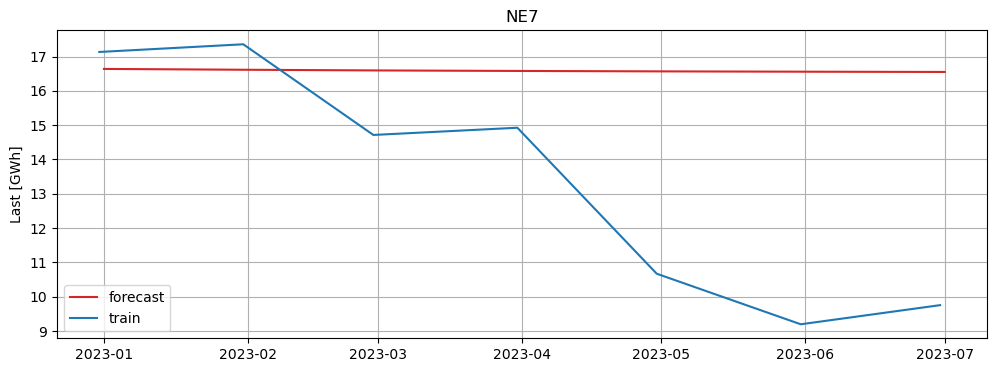

In [219]:
f, axes = plt.subplots(1, 1, figsize=(12, 4))

axes.plot(y_pred.index.to_timestamp(how="end"), y_pred.values, color="tab:red", label="forecast")
axes.plot(pdf_test, color="tab:blue", label="train")
axes.legend()
axes.set_title("NE7")
axes.set_ylabel("Last [GWh]")
axes.grid()
plt.show()

In [216]:
print(f"RMSE: {mean_squared_error(y_pred.values, pdf_test.values, squared=False)}")

RMSE: 0.6482438628753519


In [ ]:
# Debugging/Test Code

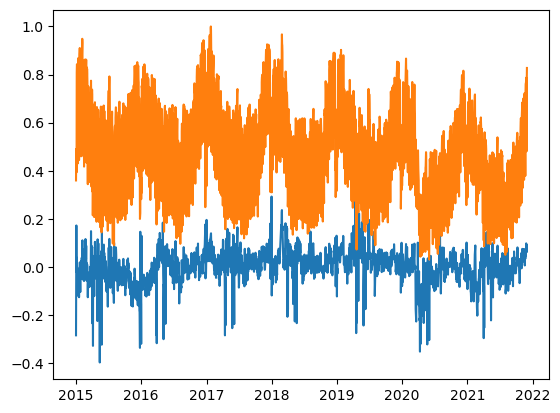

In [ ]:
#How can i plot the individual components of the model?
plt.plot(forecaster.transform(pdf_train['y']))
plt.plot(pdf_train['y'])